# Checagem de vantagens transitórias para Nereu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   

from utils_ccd import get_connection, get_info_file_path, extract_text_from_pdf

from langchain_openai import  AzureChatOpenAI
from langchain.prompts import PromptTemplate

conn = get_connection()

# Análise Planilha Relatores

In [3]:
df = pd.read_excel("analise_debitos_nereu_definitiva.xlsx")

In [4]:
sql_mais_colunas = f"""
SELECT IdDebito as id_debito, 
    StatusProtesto as status_protesto, 
    Status_PGE as status_pge
FROM processo.dbo.Exe_Debito
WHERE IdDebito IN ({','.join([f"{id_debito}" for id_debito in df['id_debito']])})
"""
df_mais_colunas = pd.read_sql(sql_mais_colunas, conn)
df = df.merge(df_mais_colunas, on='id_debito', how='left')

df['status_pge'].fillna('Sem envio à Dívida Ativa', inplace=True)

df['status_protesto'].fillna(0, inplace=True)
def protesto_status(x):
    if x == 3:
        return 'Protestada'
    elif x == 0:
        return 'Sem Protesto'
    else:
        return x
df['status_protesto'] = df['status_protesto'].apply(protesto_status)

C:\Users\05911205424\AppData\Local\Temp\ipykernel_14936\1167344976.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_mais_colunas = pd.read_sql(sql_mais_colunas, conn)
C:\Users\05911205424\AppData\Local\Temp\ipykernel_14936\1167344976.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['status_pge'].fillna('Sem envio à Dívida Ativa', inplace=True)
C:\Users\0591120

In [5]:
df.head()

,id_debito,processo_origem,processo_execucao,orgao_envolvido_processo_origem,tipo_processo_origem,tipo_multa,valor_multa,relator,status_divida,servidores_envolvidos,...,texto_acordaos,ementas_decisoes,relatorios_decisoes,votos_decisoes,verbas_transitorias,vt1,trechos_verba_voto,sesap,status_protesto,status_pge
0,2760,007433/2005,001081/2015,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,136.58,RENATO COSTA DIAS,Cancelada por prescrição,Sem servidores envolvidos,...,Sem decisões,Sem decisões,NaN,NaN,Inconclusivo,Inconclusivo,NaN,OUTROS,Sem Protesto,Sem envio à Dívida Ativa
1,10979,002113/2009,Sem processo de execução,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,118.11,PAULO ROBERTO CHAVES ALVES,Cancelada por prescrição,Sem servidores envolvidos,...,Sem decisões,Sem decisões,NaN,NaN,Inconclusivo,Inconclusivo,NaN,OUTROS,Sem Protesto,Sem envio à Dívida Ativa
2,19752,012078/2012,012970/2017,NaN,PAG,Multa,9858.52,CARLOS THOMPSON COSTA FERNANDES,Cancelada por Erro de Cadastro,Maria das Graças Fernandes Costa da Motta,...,"Vistos, relatados e discutidos estes autos, em...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO E FINAN...,Cuida o presente feito do exame de pagamento r...,"No caso dos autos, imputa-se à gestora respons...",Outros assuntos,Outros assuntos,Não há verba transitória mencionada no voto.,OUTROS,Sem Protesto,Sem envio à Dívida Ativa
3,19809,100897/2019,Sem processo de execução,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,11668.00,MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO,Cancelada por Erro de Cadastro,MARIA LUCIA SALVIANO DE OLIVEIRA,...,"Vistos, relatados e discutidos estes autos de ...",EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Trata-se de Aposentadoria voluntária por tempo...,"\tInicialmente, verifico que o retorno dos pre...",Outros assuntos,Outros assuntos,"```\n1. ""a qual determinou que a autoridade co...",SESAP,Sem Protesto,Sem envio à Dívida Ativa
4,19810,101097/2019,Sem processo de execução,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,11750.84,MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO,Cancelada por Erro de Cadastro,MARCOS ANTONIO BEZERRA CAVALCANTI,...,"Vistos, relatados e discutidos estes autos, em...",EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Trata-se de Aposentadoria voluntária por tempo...,"Inicialmente, verifico que o retorno dos prese...",Outros assuntos,Outros assuntos,"""no tocante a incorporação indevida de vantage...",SESAP,Sem Protesto,Sem envio à Dívida Ativa


In [6]:
df['processo_setor'] = df.apply(lambda row: row['processo_execucao'] if row['processo_execucao'] != 'Sem processo de execução' else row['processo_origem'], axis=1)

In [7]:
df[['processo_origem', 'processo_execucao', 'processo_setor']]

,processo_origem,processo_execucao,processo_setor
0,007433/2005,001081/2015,001081/2015
1,002113/2009,Sem processo de execução,002113/2009
2,012078/2012,012970/2017,012970/2017
3,100897/2019,Sem processo de execução,100897/2019
4,101097/2019,Sem processo de execução,101097/2019
...,...,...,...
644,018875/2016,Sem processo de execução,018875/2016
645,022595/2016,Sem processo de execução,022595/2016
646,019247/2016,Sem processo de execução,019247/2016
647,026373/2016,Sem processo de execução,026373/2016


In [8]:
sql_setor_atual = f"""
SELECT CONCAT(numero_processo, '/', ano_processo) as processo_setor, setor_atual
FROM Processo.dbo.Processos p 
WHERE CONCAT(numero_processo, '/', ano_processo) IN ({','.join([f"'{p}'" for p in df['processo_setor']])})
"""
df_setor_atual = pd.read_sql(sql_setor_atual, conn)

C:\Users\05911205424\AppData\Local\Temp\ipykernel_14936\2133988538.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_setor_atual = pd.read_sql(sql_setor_atual, conn)


In [9]:
df = df.merge(df_setor_atual, on='processo_setor', how='left')

In [10]:
df.columns

Index(['id_debito', 'processo_origem', 'processo_execucao',
       'orgao_envolvido_processo_origem', 'tipo_processo_origem', 'tipo_multa',
       'valor_multa', 'relator', 'status_divida', 'servidores_envolvidos',
       'orgaos_servidores_envolvidos', 'texto_acordaos', 'ementas_decisoes',
       'relatorios_decisoes', 'votos_decisoes', 'verbas_transitorias', 'vt1',
       'trechos_verba_voto', 'sesap', 'status_protesto', 'status_pge',
       'processo_setor', 'setor_atual'],
      dtype='object')

In [11]:
sql_relator = f""" 
SELECT CONCAT(pro.numero_processo, '/', pro.ano_processo) as processo, 
r.nome as relator
FROM
processo.dbo.Processos pro LEFT JOIN processo.dbo.Relator r ON r.codigo = pro.codigo_relator 
"""
df_relator = pd.read_sql(sql_relator, conn)

C:\Users\05911205424\AppData\Local\Temp\ipykernel_14936\336620820.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_relator = pd.read_sql(sql_relator, conn)


In [12]:
df = df.merge(df_relator, right_on='processo', left_on='processo_execucao', how='left', suffixes=('', '_execucaox'))
df = df.merge(df_relator, right_on='processo', left_on='processo_origem', how='left', suffixes=('', '_origemx'))

In [13]:
df.columns

Index(['id_debito', 'processo_origem', 'processo_execucao',
       'orgao_envolvido_processo_origem', 'tipo_processo_origem', 'tipo_multa',
       'valor_multa', 'relator', 'status_divida', 'servidores_envolvidos',
       'orgaos_servidores_envolvidos', 'texto_acordaos', 'ementas_decisoes',
       'relatorios_decisoes', 'votos_decisoes', 'verbas_transitorias', 'vt1',
       'trechos_verba_voto', 'sesap', 'status_protesto', 'status_pge',
       'processo_setor', 'setor_atual', 'processo', 'relator_execucaox',
       'processo_origemx', 'relator_origemx'],
      dtype='object')

In [14]:
df['relator_execucaox'].fillna('Sem relator', inplace=True)

C:\Users\05911205424\AppData\Local\Temp\ipykernel_14936\4131723428.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['relator_execucaox'].fillna('Sem relator', inplace=True)


In [15]:
df_descontos = pd.read_excel("descontos_folha_nereu.xlsx")
df_descontos['numero_processo'] = df_descontos['numero_processo'].astype(str).str.zfill(6)
df_descontos['processo'] = df_descontos['numero_processo'] + '/' + df_descontos['ano_processo'].astype(str)

In [16]:
df['desconto_folha'] = df['processo_execucao'].apply(lambda x: 'Desconto em folha implantado' if len(df_descontos[df_descontos['processo'] == x]) > 0 else 'Sem desconto em folha')

In [17]:
df['relator'] = df['relator'].apply(lambda x: 'ANTONIO ED SOUZA SANTANA' if 'ANTONIO ED SOUZA SANTANA' in x else x)

In [18]:
df.rename(columns={'relator': 'relator_original'}, inplace=True)

In [19]:
df.columns

Index(['id_debito', 'processo_origem', 'processo_execucao',
       'orgao_envolvido_processo_origem', 'tipo_processo_origem', 'tipo_multa',
       'valor_multa', 'relator_original', 'status_divida',
       'servidores_envolvidos', 'orgaos_servidores_envolvidos',
       'texto_acordaos', 'ementas_decisoes', 'relatorios_decisoes',
       'votos_decisoes', 'verbas_transitorias', 'vt1', 'trechos_verba_voto',
       'sesap', 'status_protesto', 'status_pge', 'processo_setor',
       'setor_atual', 'processo', 'relator_execucaox', 'processo_origemx',
       'relator_origemx', 'desconto_folha'],
      dtype='object')

In [20]:
df.relator_original.unique()

array(['RENATO COSTA DIAS', 'PAULO ROBERTO CHAVES ALVES',
       'CARLOS THOMPSON COSTA FERNANDES',
       'MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO',
       'ANA PAULA DE OLIVEIRA GOMES', 'ANTONIO ED SOUZA SANTANA',
       'ANTONIO GILBERTO DE OLIVEIRA JALES', 'MARIA ADÉLIA SALES',
       'GEORGE MONTENEGRO SOARES', 'FRANCISCO POTIGUAR CAVALCANTI JÚNIOR'],
      dtype=object)

In [21]:
def get_relator(row):
    if pd.isna(row['relator_execucaox']) or row['relator_execucaox'] == 'Sem relator':
        return row['relator_origemx']
    return row['relator_execucaox']
df['relator'] = df.apply(get_relator, axis=1)

In [22]:
df[['relator_origemx', 'relator_execucaox', 'relator']]

,relator_origemx,relator_execucaox,relator
0,RENATO COSTA DIAS,RENATO COSTA DIAS,RENATO COSTA DIAS
1,PAULO ROBERTO CHAVES ALVES,Sem relator,PAULO ROBERTO CHAVES ALVES
2,CARLOS THOMPSON COSTA FERNANDES,CARLOS THOMPSON COSTA FERNANDES,CARLOS THOMPSON COSTA FERNANDES
3,MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO,Sem relator,MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO
4,MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO,Sem relator,MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO
...,...,...,...
644,RENATO COSTA DIAS,Sem relator,RENATO COSTA DIAS
645,RENATO COSTA DIAS,Sem relator,RENATO COSTA DIAS
646,RENATO COSTA DIAS,Sem relator,RENATO COSTA DIAS
647,RENATO COSTA DIAS,Sem relator,RENATO COSTA DIAS


In [23]:
df.columns

Index(['id_debito', 'processo_origem', 'processo_execucao',
       'orgao_envolvido_processo_origem', 'tipo_processo_origem', 'tipo_multa',
       'valor_multa', 'relator_original', 'status_divida',
       'servidores_envolvidos', 'orgaos_servidores_envolvidos',
       'texto_acordaos', 'ementas_decisoes', 'relatorios_decisoes',
       'votos_decisoes', 'verbas_transitorias', 'vt1', 'trechos_verba_voto',
       'sesap', 'status_protesto', 'status_pge', 'processo_setor',
       'setor_atual', 'processo', 'relator_execucaox', 'processo_origemx',
       'relator_origemx', 'desconto_folha', 'relator'],
      dtype='object')

In [24]:
df_tabelas = df[(df['sesap'] == 'SESAP') & (df['vt1'] == 'Verba transitória')][['relator', 'processo_origem','processo_execucao', 
                                                                                'tipo_multa', 'valor_multa', 'vt1', 'desconto_folha',
                                                                                'status_protesto', 'status_pge']].copy()
df_tabelas.rename(columns={ 'relator': 'Relator',
                            'vt1': 'Assunto', 
                           'processo_origem': 'Processo Origem',
                           'processo_execucao': 'Processo Execução',
                            'tipo_multa': 'Tipo da Multa',
                            'valor_multa': 'Valor da Multa',
                            'desconto_folha': 'Desconto em Folha',
                            'status_protesto': 'Status Protesto',
                            'status_pge': 'Status PGE'
                           }, inplace=True)

In [25]:
relatores = df_tabelas["Relator"].sort_values().unique().tolist()
tabs = []
for relator in relatores:
    print(relator)
    df_relator = df_tabelas[(df_tabelas["Relator"] == relator)]
    #df_relator = df_relator.sort_values(by="data")
    tabs.append(df_relator)

ANA PAULA DE OLIVEIRA GOMES
ANTONIO ED SOUZA SANTANA
ANTONIO GILBERTO DE OLIVEIRA JALES
CARLOS THOMPSON COSTA FERNANDES
FRANCISCO POTIGUAR CAVALCANTI JÚNIOR
MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO
PAULO ROBERTO CHAVES ALVES
RENATO COSTA DIAS


In [26]:
with pd.ExcelWriter('processos_nereu_gabinetes.xlsx') as writer:
    for relator, tab in zip(relatores, tabs):
        sheet_name = relator[:31]
        tab.to_excel(writer, sheet_name=sheet_name, index=False)

# Análise multas livres para cobrança

In [149]:
df_livre = df[(df['sesap'] != 'SESAP') & (df['vt1'] != 'Verba transitória')].copy()

In [177]:
df_livre['setor_atual'] = df_livre.setor_atual.str.strip()

In [183]:
fora_ccd = df_livre[df_livre['setor_atual'] != 'CCD']
ccd = df_livre[df_livre['setor_atual'] == 'CCD']

In [179]:
len(fora_ccd), len(df_livre)

(37, 99)

In [185]:
ccd.sort_values(by='valor_multa', ascending=False).head(10)[['processo_execucao', 'valor_multa', 'relator']]

,processo_execucao,valor_multa,relator
85,001361/2022,35531.71,ANTONIO GILBERTO DE OLIVEIRA JALES
167,003654/2022,32444.33,PAULO ROBERTO CHAVES ALVES
214,002716/2022,32432.20,ANTONIO GILBERTO DE OLIVEIRA JALES
337,012970/2017,30380.00,CARLOS THOMPSON COSTA FERNANDES
166,001425/2022,29559.75,ANTONIO GILBERTO DE OLIVEIRA JALES
227,003061/2022,29511.64,ANTONIO GILBERTO DE OLIVEIRA JALES
278,002742/2022,29443.88,ANTONIO GILBERTO DE OLIVEIRA JALES
170,001424/2022,29185.44,ANTONIO GILBERTO DE OLIVEIRA JALES
84,000157/2022,29176.41,ANTONIO GILBERTO DE OLIVEIRA JALES
88,001365/2022,29109.42,ANTONIO GILBERTO DE OLIVEIRA JALES


In [186]:
fora_ccd.groupby('setor_atual').size().sort_values(ascending=False).reset_index()

,setor_atual,0
0,CBP,19
1,ARQUI,10
2,DE_EXP,4
3,DAE_SOB,2
4,PROC_EXE,2


In [187]:
df_livre['relator'] = df_livre['relator'].apply(lambda x: 'ANTONIO ED SOUZA SANTANA' if 'ANTONIO ED SOUZA SANTANA' in x else x)

In [188]:
df_livre.groupby('relator').size().sort_values(ascending=False)

relator
ANTONIO GILBERTO DE OLIVEIRA JALES         49
ANTONIO ED SOUZA SANTANA                   18
CARLOS THOMPSON COSTA FERNANDES            16
PAULO ROBERTO CHAVES ALVES                  5
MARIA ADÉLIA SALES                          4
FRANCISCO POTIGUAR CAVALCANTI JÚNIOR        3
RENATO COSTA DIAS                           3
MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO     1
dtype: int64

In [189]:
df_relatores = {}
for relator in df_livre['relator'].unique():
    if 'GILBERTO' in relator:
        nome_relator = 'gilberto'
    elif 'ANTONIO ED SOUZA SANTANA' in relator:
        nome_relator = 'antonio_ed'
    elif 'POTI' in relator:
        nome_relator = 'poti'
    else:
        nome_relator = relator.split()[0].lower()
    df_relatores[nome_relator] = df_livre[df_livre['relator'] == relator][['processo_origem', 'processo_execucao', 
                                                                     'tipo_multa', 'valor_multa', 'vt1', 'desconto_folha',
                                                                     'status_protesto', 'status_pge', 'setor_atual']].copy()
    df_relatores[nome_relator].rename(columns={ 'vt1': 'Assunto', 
                                           'processo_origem': 'Processo Origem',
                                           'processo_execucao': 'Processo Execução',
                                           'tipo_multa': 'Tipo da Multa',
                                           'valor_multa': 'Valor da Multa',
                                           'desconto_folha': 'Desconto em Folha',
                                           'status_protesto': 'Status Protesto',
                                           'status_pge': 'Status PGE',
                                             'setor_atual': 'Setor Atual'
                                          }, inplace=True)

In [202]:
ccd.columns

Index(['id_debito', 'processo_origem', 'processo_execucao',
       'orgao_envolvido_processo_origem', 'tipo_processo_origem', 'tipo_multa',
       'valor_multa', 'relator_original', 'status_divida',
       'servidores_envolvidos', 'orgaos_servidores_envolvidos',
       'texto_acordaos', 'ementas_decisoes', 'relatorios_decisoes',
       'votos_decisoes', 'verbas_transitorias', 'vt1', 'trechos_verba_voto',
       'sesap', 'status_protesto', 'status_pge', 'processo_setor',
       'setor_atual', 'processo', 'relator_execucaox', 'processo_origemx',
       'relator_origemx', 'desconto_folha', 'relator'],
      dtype='object')

In [204]:
ccd[['processo_origem', 'processo_execucao', 'relator', 'valor_multa', 'status_protesto', 'status_pge']].to_excel('processos_nereu_ccd_nao_sesap.xlsx', index=False)

In [190]:
df_relatores.keys()

dict_keys(['renato', 'paulo', 'carlos', 'maria', 'antonio_ed', 'gilberto', 'marco', 'poti'])

In [194]:
gilberto = df_relatores['gilberto']

In [195]:
gilberto_ccd = gilberto[gilberto['Setor Atual'] == 'CCD']

In [196]:
gilberto_ccd

,Processo Origem,Processo Execução,Tipo da Multa,Valor da Multa,Assunto,Desconto em Folha,Status Protesto,Status PGE,Setor Atual
24,016395/2016,000133/2022,Multa,26339.33,Outros assuntos,Sem desconto em folha,Sem Protesto,Sem envio à Dívida Ativa,CCD
61,013371/2017,000101/2022,Multa,14081.63,Outros assuntos,Sem desconto em folha,Sem Protesto,Sem envio à Dívida Ativa,CCD
66,002545/2017,000112/2022,Multa,13950.50,Outros assuntos,Sem desconto em folha,Sem Protesto,Sem envio à Dívida Ativa,CCD
67,004165/2017,000116/2022,Multa,13950.50,Outros assuntos,Sem desconto em folha,Sem Protesto,Sem envio à Dívida Ativa,CCD
69,004874/2017,000152/2022,Multa,14081.63,Outros assuntos,Sem desconto em folha,Sem Protesto,Sem envio à Dívida Ativa,CCD
70,005552/2017,000115/2022,Multa,13950.50,Outros assuntos,Sem desconto em folha,Sem Protesto,Sem envio à Dívida Ativa,CCD
71,007606/2017,000111/2022,Multa,13950.50,Outros assuntos,Sem desconto em folha,Sem Protesto,Sem envio à Dívida Ativa,CCD
74,001202/2016,000129/2022,Multa,14081.63,Outros assuntos,Sem desconto em folha,Sem Protesto,Sem envio à Dívida Ativa,CCD
75,001302/2017,000125/2022,Multa,13950.50,Outros assuntos,Sem desconto em folha,Sem Protesto,Sem envio à Dívida Ativa,CCD
84,002625/2017,000157/2022,Multa,29176.41,Outros assuntos,Sem desconto em folha,Sem Protesto,Sem envio à Dívida Ativa,CCD


# Protesto

In [27]:
ana = df[(df["relator"].str.contains("ANA PAU"))]
gilberto = df[(df["relator"].str.contains("GILBERTO"))]
renato = df[(df["relator"].str.contains("RENATO"))]
ed = df[(df["relator"].str.contains("ANTONIO ED"))]

In [28]:
ed

,id_debito,processo_origem,processo_execucao,orgao_envolvido_processo_origem,tipo_processo_origem,tipo_multa,valor_multa,relator_original,status_divida,servidores_envolvidos,...,status_protesto,status_pge,processo_setor,setor_atual,processo,relator_execucaox,processo_origemx,relator_origemx,desconto_folha,relator
9,21475,101908/2018,000137/2022,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,14267.67,ANTONIO ED SOUZA SANTANA,Em Aberto,FRANCISCO LOPES VIEIRA,...,Sem Protesto,Sem envio à Dívida Ativa,000137/2022,CCD,000137/2022,ANTONIO ED SOUZA SANTANA,101908/2018,ANTONIO ED SOUZA SANTANA,Sem desconto em folha,ANTONIO ED SOUZA SANTANA
10,21476,101678/2018,000135/2022,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,14267.67,ANTONIO GILBERTO DE OLIVEIRA JALES,Em Aberto,ELSON FERREIRA,...,Sem Protesto,Sem envio à Dívida Ativa,000135/2022,CCD,000135/2022,ANTONIO ED SOUZA SANTANA,101678/2018,ANTONIO GILBERTO DE OLIVEIRA JALES,Sem desconto em folha,ANTONIO ED SOUZA SANTANA
11,21477,101184/2018,000134/2022,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,13994.41,ANTONIO ED SOUZA SANTANA,Em Aberto,FRANCISCO EDIMAR FERREIRA,...,Sem Protesto,Sem envio à Dívida Ativa,000134/2022,CCD,000134/2022,ANTONIO ED SOUZA SANTANA,101184/2018,ANTONIO ED SOUZA SANTANA,Sem desconto em folha,ANTONIO ED SOUZA SANTANA
12,21480,025012/2016,000097/2022,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,14220.06,ANTONIO ED SOUZA SANTANA,Cancelada por Erro de Cadastro,SILVESTRE MOTA CAVALCANTE,...,Sem Protesto,Sem envio à Dívida Ativa,000097/2022,GCAED_SOBR,000097/2022,ANTONIO ED SOUZA SANTANA,025012/2016,ANTONIO ED SOUZA SANTANA,Sem desconto em folha,ANTONIO ED SOUZA SANTANA
13,21481,017996/2017,000151/2022,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,14222.91,ANTONIO ED SOUZA SANTANA,Em Aberto,ROSSANA MARCIA OLIVEIRA DE MEDEIROS,...,Sem Protesto,Sem envio à Dívida Ativa,000151/2022,CCD,000151/2022,ANTONIO ED SOUZA SANTANA,017996/2017,ANTONIO ED SOUZA SANTANA,Sem desconto em folha,ANTONIO ED SOUZA SANTANA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,27531,101880/2019,003382/2024,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa Cominatória,12650.52,FRANCISCO POTIGUAR CAVALCANTI JÚNIOR,Em Aberto,ROSANGELA MARIA DA SILVA OLIVEIRA MORAIS,...,Sem Protesto,Sem envio à Dívida Ativa,003382/2024,CCD,003382/2024,ANTONIO ED SOUZA SANTANA,101880/2019,FRANCISCO POTIGUAR CAVALCANTI JÚNIOR,Sem desconto em folha,ANTONIO ED SOUZA SANTANA
546,27532,101636/2019,003380/2024,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa Cominatória,13319.44,GEORGE MONTENEGRO SOARES,Em Aberto,MARIA DO CARMO MEDEIROS ALVES,...,Sem Protesto,Sem envio à Dívida Ativa,003380/2024,CCD,003380/2024,ANTONIO ED SOUZA SANTANA,101636/2019,GEORGE MONTENEGRO SOARES,Sem desconto em folha,ANTONIO ED SOUZA SANTANA
547,27533,101759/2019,003397/2024,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa Cominatória,13132.54,GEORGE MONTENEGRO SOARES,Em Aberto,TERESINHA MOURA DE SOUZA,...,Protestada,Sem envio à Dívida Ativa,003397/2024,CCD,003397/2024,ANTONIO ED SOUZA SANTANA,101759/2019,GEORGE MONTENEGRO SOARES,Sem desconto em folha,ANTONIO ED SOUZA SANTANA
548,27534,101696/2019,003394/2024,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa Cominatória,12511.44,ANA PAULA DE OLIVEIRA GOMES,Em Aberto,INACIO TEODORO DA CRUZ,...,Sem Protesto,Sem envio à Dívida Ativa,003394/2024,CCD,003394/2024,ANTONIO ED SOUZA SANTANA,101696/2019,ANA PAULA DE OLIVEIRA GOMES,Sem desconto em folha,ANTONIO ED SOUZA SANTANA


In [24]:
renato.id_debito.unique()

array([ 2760, 27256, 27257, 27945, 28188, 28189, 28190, 28247, 28248,
       28249, 28250, 28251, 28252, 28253, 28259, 28260, 28261])

In [24]:
len(ana)

34

In [25]:
len(ana.processo_origem.unique())

27

In [26]:
ana.id_debito.unique()

array([20753, 21698, 22691, 22693, 22695, 22702, 22704, 22706, 22708,
       22710, 22712, 22741, 22744, 22746, 22747, 23031, 27131, 27132,
       27133, 27134, 27135, 27136, 27156, 27157, 27158, 27163, 27164,
       27165, 27166, 27167, 27169, 27295, 27299, 27535])

In [27]:
len(df.processo_origem.unique())

566

In [ ]:
sql_setor_atual = f""" 
SELECT CONCAT(pro.numero_processo, '/', pro.ano_processo) as processo,
pro.setor_atual
FROM
processo.dbo.Processos pro
WHERE CONCAT(pro.numero_processo, '/', pro.ano_processo) IN ({','.join([f"'{p}'" for p in df['processo_execucao']])}) 
"""
df_setor_atual = pd.read_sql(sql_setor_atual, conn)

C:\Users\05911205424\AppData\Local\Temp\ipykernel_15064\587876536.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_setor_atual = pd.read_sql(sql_setor_atual, conn)


In [17]:
outros = df[(df['sesap'] != 'SESAP') | ((df['sesap'] == 'SESAP') & (df['vt1'] != 'Verba transitória'))]

In [18]:
outros.loc[outros.processo_origem.isin(['015303/2006', '008669/2010', '003461/2022']), 'vt1'] = 'Verba transitória'

In [19]:
outros.loc[outros.processo_origem.str.contains('3461')]

,id_debito,processo_origem,processo_execucao,orgao_envolvido_processo_origem,tipo_processo_origem,tipo_multa,valor_multa,relator_original,status_divida,servidores_envolvidos,...,verbas_transitorias,vt1,trechos_verba_voto,sesap,status_protesto,status_pge,processo,relator_execucao,desconto_folha,relator


# Todos os débitos

In [160]:
sql_debitos_nereu_query = """
SELECT DISTINCT 
        ed.IdDebito as id_debito,
        gp.Documento,
        gp.Nome,
       CONCAT(pro_exe.numero_processo, '/', pro_exe.ano_processo) as processo_execucao,
       pro_orig.codigo_tipo_processo,
       pro_exe.assunto,
       etd.Descricao as tipo_multa,
       edmc.DataFinalImputacaoMultaCominatoria as data_final_cominatoria,
       CONCAT(gp.Nome, ' (CPF: ', gp.Documento, ')') as nome,
       processo.dbo.fn_Exe_RetornaValorAtualizado(ed.IdDebito) as valor_multa,
       r.nome as relator,
       ed.IdProcessoOrigem as id_processo_origem,
       (
        SELECT CONCAT(numero_processo, '/', ano_processo)
        FROM processo.dbo.Processos
        WHERE IdProcesso = ed.IdProcessoOrigem
       ) as processo_origem,
       pro_orig.codigo_tipo_processo as tipo_processo_origem,
       (
        SELECT o.nome
		FROM processo.dbo.Orgaos o
		WHERE o.IdOrgao = pro_orig.IdOrgaoEnvolvido
       ) as orgao_envolvido_processo_origem,
       ed.IdProcessoExecucao as id_processo_execucao,
       esd.DescricaoStatusDivida as status_divida
	FROM processo.dbo.Exe_Debito ed 
	LEFT JOIN processo.dbo.Processos pro_orig ON ed.IdProcessoOrigem = pro_orig.IdProcesso
	LEFT JOIN processo.dbo.Processos pro_exe ON ed.IdProcessoExecucao = pro_exe.IdProcesso
	LEFT JOIN processo.dbo.Relator r ON r.codigo = pro_orig.codigo_relator 
	LEFT JOIN processo.dbo.Exe_DebitoPessoa edp ON edp.IDDebito = ed.IdDebito
	LEFT JOIN processo.dbo.Exe_TipoDebito etd ON etd.CodigoTipoDebito = ed.CodigoTipoDebito
	LEFT JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = edp.IDPessoa
	LEFT JOIN processo.dbo.Exe_StatusDivida esd ON esd.CodigoStatusDivida = ed.CodigoStatusDivida
	LEFT JOIN processo.dbo.Exe_Debito_MultaCominatoria edmc ON ed.IdDebito = edmc.IdDebito
	WHERE gp.Documento = '13006444434'

"""
df_debitos_nereu = pd.read_sql(sql_debitos_nereu_query, conn)

C:\Users\05911205424\AppData\Local\Temp\ipykernel_14556\2946385371.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_debitos_nereu = pd.read_sql(sql_debitos_nereu_query, conn)


In [93]:
df_debitos_nereu.columns

Index(['id_debito', 'Documento', 'Nome', 'processo_execucao',
       'codigo_tipo_processo', 'assunto', 'tipo_multa',
       'data_final_cominatoria', 'nome', 'valor_multa', 'relator',
       'id_processo_origem', 'processo_origem', 'tipo_processo_origem',
       'orgao_envolvido_processo_origem', 'id_processo_execucao',
       'status_divida'],
      dtype='object')

In [94]:
len(df_debitos_nereu)

649

In [95]:
processos_origem = df_debitos_nereu['processo_origem'].unique()

In [96]:
processos_busca = ', '.join(f"'{proc}'" for proc in processos_origem)

sql_all_informacoes_processos = f'''
SELECT concat(rtrim(inf.setor),'_',inf.numero_processo ,'_',inf.ano_processo,'_',RIGHT(concat('0000',inf.ordem),4),'.pdf') as arquivo,
ppe.SequencialProcessoEvento as evento,
CONCAT(inf.numero_processo,'/', inf.ano_processo) as processo,
inf.*
FROM processo.dbo.vw_ata_informacao inf INNER JOIN processo.dbo.Pro_ProcessoEvento ppe 
    ON inf.idinformacao = ppe.idinformacao
WHERE concat(inf.numero_processo, '/', inf.ano_processo) in ({processos_busca})
'''
all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)


C:\Users\05911205424\AppData\Local\Temp\ipykernel_14556\22331079.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)


In [7]:
help(get_info_file_path)

Help on function get_info_file_path in module utils_ccd:

get_info_file_path(row, dir_info='\\\\10.24.0.6\\tce$\\Informacoes_PDF')



In [8]:
from functools import partial
get_info_file_path_partial = partial(get_info_file_path, dir_info='/media/informacoes_pdf/')

In [9]:
all_informacoes_processos['caminho_arquivo'] = all_informacoes_processos.apply(get_info_file_path, axis=1)

In [10]:
all_informacoes_processos['caminho_arquivo']

0        \\10.24.0.6\tce$\Informacoes_PDF\DAP\DAP_00460...
1        \\10.24.0.6\tce$\Informacoes_PDF\DE\DE_004784_...
2        \\10.24.0.6\tce$\Informacoes_PDF\DE\DE_000593_...
3        \\10.24.0.6\tce$\Informacoes_PDF\DAP\DAP_01742...
4        \\10.24.0.6\tce$\Informacoes_PDF\PROC\PROC_004...
                               ...                        
34356    \\10.24.0.6\tce$\Informacoes_PDF\DE_EXP\DE_EXP...
34357    \\10.24.0.6\tce$\Informacoes_PDF\DE_EXP\DE_EXP...
34358    \\10.24.0.6\tce$\Informacoes_PDF\DE_EXP\DE_EXP...
34359    \\10.24.0.6\tce$\Informacoes_PDF\DE_EXP\DE_EXP...
34360    \\10.24.0.6\tce$\Informacoes_PDF\DE_EXP\DE_EXP...
Name: caminho_arquivo, Length: 34361, dtype: object

In [11]:
all_informacoes_processos['resumo'].fillna('', inplace=True)

C:\Users\05911205424\AppData\Local\Temp\ipykernel_14556\1279296039.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_informacoes_processos['resumo'].fillna('', inplace=True)


In [12]:
decisoes = f'''
SELECT numeroprocesso, anoprocesso, fundamentacaovoto, votoescolhido, ementa, texto_acordao, relatorio
FROM processo.dbo.vw_ia_votos_acordaos_decisoes
WHERE concat(numeroprocesso, '/', anoprocesso) in ({processos_busca})
AND VotoEscolhido = 1
'''
df_decisoes = pd.read_sql(decisoes, conn)

C:\Users\05911205424\AppData\Local\Temp\ipykernel_14556\4069007640.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_decisoes = pd.read_sql(decisoes, conn)


In [13]:
df_decisoes.columns

Index(['numeroprocesso', 'anoprocesso', 'fundamentacaovoto', 'votoescolhido',
       'ementa', 'texto_acordao', 'relatorio'],
      dtype='object')

In [14]:
df_decisoes['processo'] = df_decisoes.apply(
    lambda x: f"{x['numeroprocesso']}/{x['anoprocesso']}", axis=1
)

In [15]:
df_decisoes[['processo', 'texto_acordao']]

,processo,texto_acordao
0,003146/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
1,003391/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
2,009430/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
3,012518/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
4,014111/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
...,...,...
555,005552/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
556,025465/2016,DECIDEM os Conselheiros do Tribunal de Contas ...
557,026700/2016,DECIDEM os Conselheiros do Tribunal de Contas ...
558,012211/2006,DECIDEM os Conselheiros do Tribunal de Contas ...


In [16]:
decisoes_grp = df_decisoes.groupby('processo').agg({
    'texto_acordao': lambda x: '\n'.join(x.dropna().astype(str)),
    'ementa': lambda x: '\n'.join(x.dropna().astype(str)),
    'relatorio': lambda x: '\n'.join(x.dropna().astype(str)),
    'fundamentacaovoto': lambda x: '\n'.join(x.dropna().astype(str)),
}).reset_index()

In [17]:
decisoes_grp.head()

,processo,texto_acordao,ementa,relatorio,fundamentacaovoto
0,000002/2016,"Vistos, relatados e discutidos estes autos, AC...",\r\nEMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PR...,O presente processo trata de aposentadoria con...,"Faz-se mister destacar, inicialmente, que já h..."
1,000197/2004,DECIDEM os Conselheiros do Tribunal de Contas ...,APOSENTADORIA. DENEGAÇÃO DO REGISTRO DA MATÉRI...,Versam os presentes autos sobre aposentadoria ...,Analisando a matéria sob os auspícios da legal...
2,000259/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata-se da análise do ato de aposentadoria co...,Pelo que se constata nos documentos acostados ...
3,000266/2017,"Vistos, relatados e discutidos estes autos, co...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...,O presente processo trata de aposentadoria con...,"Faz-se mister destacar, inicialmente, que já h..."
4,000301/2017,"Vistos, relatados e discutidos estes autos, ac...",EMENTA: Pessoal. Aposentadoria. Denegação do r...,Cuida-se da análise da legalidade da aposentad...,Convém mencionar que o retorno dos presentes a...


In [18]:
decisoes_grp.columns

Index(['processo', 'texto_acordao', 'ementa', 'relatorio',
       'fundamentacaovoto'],
      dtype='object')

In [19]:
def is_natureza_transitoria(ementa):
    if pd.isna(ementa):
        return False
    keywords = ['propter lab', 'natureza transit', 'vantagens transit', 'vantagem transit', 'insalubrida']
    return any(keyword in ementa.lower() for keyword in keywords)

In [20]:
decisoes_grp['verbas_transitorias'] = decisoes_grp['ementa'].apply(lambda x: 'Verba Transitória' if is_natureza_transitoria(x) else 'Outros assuntos')

<Axes: xlabel='verbas_transitorias'>

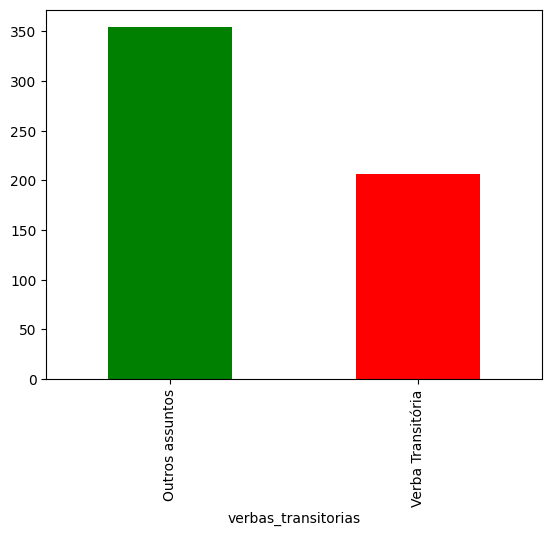

In [21]:
decisoes_grp['verbas_transitorias'].value_counts().plot(kind='bar', color=['green', 'red'])

In [22]:
llm = AzureChatOpenAI(model_name="gpt-4o")

def get_verba_voto(texto):
    try:
        prompt = PromptTemplate.from_template("""
        Você é um agente que analisa e categoriza votos de decisões do TCE/RN.
        Seu objetivo é decidir se o voto é sobre uma verba transitória ou não.
        Verbas transitórias são aquelas que possuem natureza transitória, como propter laborem, vantagens transitórias, insalubridade, etc.
        O texto do é o seguinte:
        "{input}"
                                              
        Encontre os trechos onde trata de verba transitória. Separe os trechos encontrados com uma quebra de linha.
        Se não encontrar, responda "Não há verba transitória mencionada no voto".
        
        Sua resposta:
        """)

        chain = prompt | llm
        msg_obj = chain.invoke(texto)
        return msg_obj.content
    except Exception as e:
        print(f"Error processing {texto}: {e}")
        return None
    


In [23]:
#decisoes_grp['trechos_verba_voto'] = decisoes_grp['fundamentacaovoto'].apply(get_verba_voto)
#decisoes_grp.to_excel('df_decisoes.xlsx', index=False)
decisoes_grp = pd.read_excel('df_decisoes.xlsx')

In [24]:
decisoes_grp

,processo,texto_acordao,ementa,relatorio,fundamentacaovoto,verbas_transitorias,trechos_verba_voto
0,000002/2016,"Vistos, relatados e discutidos estes autos, AC...",_x000D_\nEMENTA: CONSTITUCIONAL. ADMINISTRATIV...,O presente processo trata de aposentadoria con...,"Faz-se mister destacar, inicialmente, que já h...",Outros assuntos,"""não há verba transitória mencionada no voto."""
1,000197/2004,DECIDEM os Conselheiros do Tribunal de Contas ...,APOSENTADORIA. DENEGAÇÃO DO REGISTRO DA MATÉRI...,Versam os presentes autos sobre aposentadoria ...,Analisando a matéria sob os auspícios da legal...,Outros assuntos,"""Não há verba transitória mencionada no voto"""
2,000259/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata-se da análise do ato de aposentadoria co...,Pelo que se constata nos documentos acostados ...,Verba Transitória,"- ""esta Corte passou a resguardar o direito ad..."
3,000266/2017,"Vistos, relatados e discutidos estes autos, co...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...,O presente processo trata de aposentadoria con...,"Faz-se mister destacar, inicialmente, que já h...",Outros assuntos,Não há verba transitória mencionada no voto.
4,000301/2017,"Vistos, relatados e discutidos estes autos, ac...",EMENTA: Pessoal. Aposentadoria. Denegação do r...,Cuida-se da análise da legalidade da aposentad...,Convém mencionar que o retorno dos presentes a...,Outros assuntos,"""no tocante ao valor implantado indevidamente ..."
...,...,...,...,...,...,...,...
555,102523/2018,"Vistos, relatados e discutidos estes autos da ...",CONSTITUCIONAL. ADMINISTRATIVO. CONTROLE EXTER...,\tTrata-se de processo que tem por objeto a an...,"De início, ressalto que a matéria está sendo a...",Outros assuntos,```\nNa Informação Técnica emitida em 15/07/20...
556,102534/2018,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata-se da análise do ato de aposentadoria co...,Pelo que se constata nos documentos acostados ...,Verba Transitória,"""Pelo que se constata nos documentos acostados..."
557,102559/2018,"Vistos, relatados e discutidos estes autos, AC...",EMENTA: Constitucional. Administrativo. Aposen...,Cuida-se da análise da legalidade da aposentad...,Convém mencionar que o retorno dos presentes a...,Outros assuntos,"""no tocante a incorporação indevida de vantage..."
558,102602/2018,"Vistos, relatados e discutidos estes autos, ac...",EMENTA: Constitucional. Administrativo. Aposen...,Cuida-se da análise da legalidade da aposentad...,Convém mencionar que o retorno dos presentes a...,Outros assuntos,"""Convém mencionar que o retorno dos presentes ..."


In [36]:
votos_verba = decisoes_grp[decisoes_grp['trechos_verba_voto'] == 'Não há verba transitória mencionada no voto.']

In [37]:
print(votos_verba.iloc[0]["ementa"])

EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVIDENCIÁRIO. APOSENTADORIA.  VERIFICAÇÃO DE DESCUMPRIMENTO DE DECISÃO DESTE TCE. FLAGRANTE E INÉDITA MORA DO GESTOR RESPONSÁVEL PELO IPERN EM RELAÇÃO AO ATENDIMENTO DE EXPRESSIVO NÚMERO DE DETERMINAÇÕES DESTE TRIBUNAL, POR MAIS DE UM ANO. IMPOSIÇÃO DE MULTA POR DESCUMPRIMENTO, DIANTE DA CONDUTA OMISSIVA DO RESPONSÁVEL. PROCESSO NÃO ABRANGIDO PELO DE APURAÇÃO DE RESPONSABILDIADE Nº 003474/2021-TC INSTAURADO PARA LEVANTAMENTO DO DANO CAUSADO AO ERÁRIO PELO DESCUMPRIMENTO DE OUTRAS DECISÕES DESTA CORTE NOS ATOS DE PESSOAL DE COMPETÊNCIA DO IPERN, BEM COMO PARA IMPOSIÇÃO DE POSSÍVEIS SANÇÕES ADMINISTRATIVAS AO GESTOR OMISSO. RENOVAÇÃO DA DETERMINAÇÃO PARA QUE O GESTOR RESPONSÁVEL PELO IPERN ADOTE AS PROVIDÊNCIAS NECESSÁRIAS AO ATENDIMENTO DA DECISÃO, SOB PENA DE MULTA DIÁRIA DESDE JÁ FIXADA. DETERMINAÇÃO DE RESSARCIMENTO AO ERÁRIO, CUJO LEVANTAMENTO DOS VALORES DEVERÁ SER REALIZADO PELA DAP, SEGUINDO OS MESMOS PARÂMETROS UTILIZADOS NO PROC. Nº 003

In [38]:
#decisoes_grp.drop(columns=['categoria_ementa'], inplace=True)

In [39]:
sql_processos_origem = f'''
SELECT CONCAT(p.numero_processo, '/', p.ano_processo) as processo, gp.Documento as cpf, gp.Nome COLLATE SQL_Latin1_General_CP1_CI_AS as nome
FROM processo.dbo.Processos p INNER JOIN processo.dbo.Pro_ProcessosResponsavelDespesa pprd  ON p.IdProcesso = pprd.IdProcesso
INNER JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = pprd.IdPessoa 
WHERE CONCAT(p.numero_processo, '/', p.ano_processo) IN ({','.join([f"'{proc}'" for proc in processos_origem])})
AND gp.Documento NOT IN ('08242034000102', '13006444434') AND len(gp.Documento) = 11
'''
df_processos_origem = pd.read_sql(sql_processos_origem, conn)

C:\Users\05911205424\AppData\Local\Temp\ipykernel_14556\595497275.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_processos_origem = pd.read_sql(sql_processos_origem, conn)


In [170]:
sql_pessoas_origem = f'''SELECT DISTINCT codigo_orgao, cpf
FROM BdDIP.dbo.vwSiaiPessoalFolhaResumida fr
WHERE fr.CPF IN ({','.join([f"'{cpf}'" for cpf in df_processos_origem['cpf'].unique()])}
)
AND fr.codigo_orgao NOT IN ('IPERN')
'''
df_sql_pessoas_origem = pd.read_sql(sql_pessoas_origem, conn)


C:\Users\05911205424\AppData\Local\Temp\ipykernel_14556\3113176658.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql_pessoas_origem = pd.read_sql(sql_pessoas_origem, conn)


In [175]:
df_pessoas_origem = df_sql_pessoas_origem.groupby('cpf').agg({
    'codigo_orgao': pd.Series.tolist
}).reset_index()

processos_orgaos = df_processos_origem.merge(
    df_pessoas_origem,
    how='left',
    left_on='cpf',
    right_on='cpf',
    suffixes=('', '_pessoas')
)[['processo', 'cpf', 'nome', 'codigo_orgao']]
processos_orgaos


processos_orgaos.dropna(subset=['codigo_orgao'], inplace=True)

In [176]:
processos_orgaos.rename(columns={'codigo_orgao': 'orgaos_servidores_envolvidos', 'nome': 'servidores_envolvidos'}, inplace=True)

In [177]:
processos_orgaos_grouped = processos_orgaos.groupby('processo').agg(lambda x: list(x)).reset_index()

In [178]:
processos_orgaos_grouped['orgaos_servidores_envolvidos'] = processos_orgaos_grouped['orgaos_servidores_envolvidos'].apply(
    lambda lst: [org for sublist in lst for org in sublist] if isinstance(lst, list) else lst
)

In [179]:
processos_orgaos = processos_orgaos_grouped

In [180]:
df_debitos_nereu.columns

Index(['id_debito', 'Documento', 'Nome', 'processo_execucao',
       'codigo_tipo_processo', 'assunto', 'tipo_multa',
       'data_final_cominatoria', 'nome', 'valor_multa', 'relator',
       'id_processo_origem', 'processo_origem', 'tipo_processo_origem',
       'orgao_envolvido_processo_origem', 'id_processo_execucao',
       'status_divida'],
      dtype='object')

In [266]:
tab_debitos = df_debitos_nereu[['id_debito', 'processo_origem', 'processo_execucao', 'orgao_envolvido_processo_origem', 'tipo_processo_origem', 'tipo_multa', 'valor_multa', 'relator', 'status_divida']]

In [267]:
tab_debitos = tab_debitos.merge(
    processos_orgaos,
    how='left',
    left_on='processo_origem',
    right_on='processo',
    suffixes=('', '_orgaos')
)[['id_debito', 'processo', 'processo_origem', 'processo_execucao', 'orgao_envolvido_processo_origem', \
   'tipo_processo_origem', 'tipo_multa', 'valor_multa', 'relator', 'status_divida',\
      'servidores_envolvidos', 'orgaos_servidores_envolvidos']]

In [268]:
tab_debitos = tab_debitos.merge(
    decisoes_grp,
    how='left',
    left_on='processo_origem',
    right_on='processo',
    suffixes=('', '_decisoes')
)

In [269]:
tab_debitos.columns

Index(['id_debito', 'processo', 'processo_origem', 'processo_execucao',
       'orgao_envolvido_processo_origem', 'tipo_processo_origem', 'tipo_multa',
       'valor_multa', 'relator', 'status_divida', 'servidores_envolvidos',
       'orgaos_servidores_envolvidos', 'processo_decisoes', 'texto_acordao',
       'ementa', 'relatorio', 'fundamentacaovoto', 'verbas_transitorias',
       'trechos_verba_voto'],
      dtype='object')

In [270]:
tab_debitos.drop(columns=['processo_decisoes'], inplace=True)
tab_debitos.rename(columns={
    'texto_acordao': 'texto_acordaos',
    'ementa': 'ementas_decisoes',
    'relatorio': 'relatorios_decisoes',
    'fundamentacaovoto': 'votos_decisoes',
}, inplace=True)

In [271]:
tab_debitos['servidores_envolvidos'].fillna('Sem servidores envolvidos', inplace=True)
tab_debitos['orgaos_servidores_envolvidos'].fillna('Sem órgãos envolvidos', inplace=True)
tab_debitos['texto_acordaos'].fillna('Sem decisões', inplace=True)
tab_debitos['ementas_decisoes'].fillna('Sem decisões', inplace=True)
tab_debitos['verbas_transitorias'].fillna('', inplace=True)

C:\Users\05911205424\AppData\Local\Temp\ipykernel_14556\2124656794.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tab_debitos['servidores_envolvidos'].fillna('Sem servidores envolvidos', inplace=True)
C:\Users\05911205424\AppData\Local\Temp\ipykernel_14556\2124656794.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

In [272]:
import locale

locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

tab_debitos['valor_multa'] = tab_debitos['valor_multa'].apply(lambda x: locale.currency(x, grouping=True, symbol=False) if pd.notnull(x) else '0,00')

In [273]:
tab_debitos.drop(columns=['processo'], inplace=True)

In [274]:
tab_debitos.head()

,id_debito,processo_origem,processo_execucao,orgao_envolvido_processo_origem,tipo_processo_origem,tipo_multa,valor_multa,relator,status_divida,servidores_envolvidos,orgaos_servidores_envolvidos,texto_acordaos,ementas_decisoes,relatorios_decisoes,votos_decisoes,verbas_transitorias,trechos_verba_voto
0,2760,007433/2005,001081/2015,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,"136,58",RENATO COSTA DIAS,Cancelada por prescrição,Sem servidores envolvidos,Sem órgãos envolvidos,Sem decisões,Sem decisões,NaN,NaN,,NaN
1,10979,002113/2009,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,"118,11",PAULO ROBERTO CHAVES ALVES,Em Aberto,Sem servidores envolvidos,Sem órgãos envolvidos,Sem decisões,Sem decisões,NaN,NaN,,NaN
2,19752,012078/2012,012970/2017,None,PAG,Multa,"9.858,52",CARLOS THOMPSON COSTA FERNANDES,Cancelada por Erro de Cadastro,[Maria das Graças Fernandes Costa da Motta],"[FUNDAC, SEARH]","Vistos, relatados e discutidos estes autos, em...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO E FINAN...,Cuida o presente feito do exame de pagamento r...,"No caso dos autos, imputa-se à gestora respons...",Outros assuntos,Não há verba transitória mencionada no voto.
3,19809,100897/2019,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"11.668,00",MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO,Cancelada por Erro de Cadastro,[MARIA LUCIA SALVIANO DE OLIVEIRA],"[SEARH, SESAP]","Vistos, relatados e discutidos estes autos de ...",EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Trata-se de Aposentadoria voluntária por tempo...,"\tInicialmente, verifico que o retorno dos pre...",Outros assuntos,"```\n1. ""a qual determinou que a autoridade co..."
4,19810,101097/2019,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"11.750,84",MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO,Cancelada por Erro de Cadastro,[MARCOS ANTONIO BEZERRA CAVALCANTI],"[SEARH, SESAP]","Vistos, relatados e discutidos estes autos, em...",EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Trata-se de Aposentadoria voluntária por tempo...,"Inicialmente, verifico que o retorno dos prese...",Outros assuntos,"""no tocante a incorporação indevida de vantage..."


In [275]:
tab_debitos['orgaos_servidores_envolvidos'] = tab_debitos['orgaos_servidores_envolvidos'].apply(
    lambda lst: [org for sublist in lst for org in sublist] if isinstance(lst, list) and any(isinstance(i, list) for i in lst) else lst
)

In [276]:
tab_debitos['orgaos_servidores_envolvidos'] = tab_debitos['orgaos_servidores_envolvidos'].apply(
    lambda x: ', '.join(x) if isinstance(x, list) else x
)
tab_debitos['servidores_envolvidos'] = tab_debitos['servidores_envolvidos'].apply(
    lambda x: ', '.join(x) if isinstance(x, list) else x
)

In [277]:
tab_debitos.head()

,id_debito,processo_origem,processo_execucao,orgao_envolvido_processo_origem,tipo_processo_origem,tipo_multa,valor_multa,relator,status_divida,servidores_envolvidos,orgaos_servidores_envolvidos,texto_acordaos,ementas_decisoes,relatorios_decisoes,votos_decisoes,verbas_transitorias,trechos_verba_voto
0,2760,007433/2005,001081/2015,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,"136,58",RENATO COSTA DIAS,Cancelada por prescrição,Sem servidores envolvidos,Sem órgãos envolvidos,Sem decisões,Sem decisões,NaN,NaN,,NaN
1,10979,002113/2009,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,"118,11",PAULO ROBERTO CHAVES ALVES,Em Aberto,Sem servidores envolvidos,Sem órgãos envolvidos,Sem decisões,Sem decisões,NaN,NaN,,NaN
2,19752,012078/2012,012970/2017,None,PAG,Multa,"9.858,52",CARLOS THOMPSON COSTA FERNANDES,Cancelada por Erro de Cadastro,Maria das Graças Fernandes Costa da Motta,"FUNDAC, SEARH","Vistos, relatados e discutidos estes autos, em...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO E FINAN...,Cuida o presente feito do exame de pagamento r...,"No caso dos autos, imputa-se à gestora respons...",Outros assuntos,Não há verba transitória mencionada no voto.
3,19809,100897/2019,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"11.668,00",MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO,Cancelada por Erro de Cadastro,MARIA LUCIA SALVIANO DE OLIVEIRA,"SEARH, SESAP","Vistos, relatados e discutidos estes autos de ...",EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Trata-se de Aposentadoria voluntária por tempo...,"\tInicialmente, verifico que o retorno dos pre...",Outros assuntos,"```\n1. ""a qual determinou que a autoridade co..."
4,19810,101097/2019,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"11.750,84",MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO,Cancelada por Erro de Cadastro,MARCOS ANTONIO BEZERRA CAVALCANTI,"SEARH, SESAP","Vistos, relatados e discutidos estes autos, em...",EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Trata-se de Aposentadoria voluntária por tempo...,"Inicialmente, verifico que o retorno dos prese...",Outros assuntos,"""no tocante a incorporação indevida de vantage..."


In [278]:
tab_debitos['servidores_envolvidos'] = tab_debitos['servidores_envolvidos'].apply(
    lambda x: ', '.join(x) if isinstance(x, list) else x
)

In [279]:
tab_debitos.head()

,id_debito,processo_origem,processo_execucao,orgao_envolvido_processo_origem,tipo_processo_origem,tipo_multa,valor_multa,relator,status_divida,servidores_envolvidos,orgaos_servidores_envolvidos,texto_acordaos,ementas_decisoes,relatorios_decisoes,votos_decisoes,verbas_transitorias,trechos_verba_voto
0,2760,007433/2005,001081/2015,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,"136,58",RENATO COSTA DIAS,Cancelada por prescrição,Sem servidores envolvidos,Sem órgãos envolvidos,Sem decisões,Sem decisões,NaN,NaN,,NaN
1,10979,002113/2009,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,"118,11",PAULO ROBERTO CHAVES ALVES,Em Aberto,Sem servidores envolvidos,Sem órgãos envolvidos,Sem decisões,Sem decisões,NaN,NaN,,NaN
2,19752,012078/2012,012970/2017,None,PAG,Multa,"9.858,52",CARLOS THOMPSON COSTA FERNANDES,Cancelada por Erro de Cadastro,Maria das Graças Fernandes Costa da Motta,"FUNDAC, SEARH","Vistos, relatados e discutidos estes autos, em...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO E FINAN...,Cuida o presente feito do exame de pagamento r...,"No caso dos autos, imputa-se à gestora respons...",Outros assuntos,Não há verba transitória mencionada no voto.
3,19809,100897/2019,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"11.668,00",MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO,Cancelada por Erro de Cadastro,MARIA LUCIA SALVIANO DE OLIVEIRA,"SEARH, SESAP","Vistos, relatados e discutidos estes autos de ...",EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Trata-se de Aposentadoria voluntária por tempo...,"\tInicialmente, verifico que o retorno dos pre...",Outros assuntos,"```\n1. ""a qual determinou que a autoridade co..."
4,19810,101097/2019,/,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"11.750,84",MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO,Cancelada por Erro de Cadastro,MARCOS ANTONIO BEZERRA CAVALCANTI,"SEARH, SESAP","Vistos, relatados e discutidos estes autos, em...",EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Trata-se de Aposentadoria voluntária por tempo...,"Inicialmente, verifico que o retorno dos prese...",Outros assuntos,"""no tocante a incorporação indevida de vantage..."


In [280]:
def is_sesap(row):
    try:
        return 'SESAP' if 'SESAP' in row['orgaos_servidores_envolvidos'] or 'SAÚDE' in row['orgao_envolvido_processo_origem'] else 'OUTROS'
    except Exception as e:
        return 'OUTROS'

tab_debitos['sesap'] = tab_debitos.apply(is_sesap, axis=1)

In [281]:
tab_debitos['verbas_transitorias'] = tab_debitos['verbas_transitorias'].apply(lambda x: 'Inconclusivo' if x == '' else x)

In [282]:
tab_debitos['trechos_verba_voto'].fillna('', inplace=True)

C:\Users\05911205424\AppData\Local\Temp\ipykernel_14556\3598057514.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tab_debitos['trechos_verba_voto'].fillna('', inplace=True)


In [283]:
tab_debitos['sesap'].value_counts() 

sesap
SESAP     545
OUTROS    104
Name: count, dtype: int64

In [284]:
tab_debitos['processo_execucao'] = tab_debitos['processo_execucao'].apply(lambda x: 'Sem processo de execução' if x == '/' else x )

In [285]:
tab_debitos.to_excel('debitos_processos_nereu.xlsx', index=False)

In [286]:
mask = tab_debitos['votos_decisoes'].str.contains('Faz-se mister destacar, inicialmente, que já houve pronunciamento deste Tribunal, de sorte que não há que se falar em incidência, neste feito, do quanto assentado no Tema 445 de Repercussão Geral', na=False)
tab_debitos.loc[mask, 'trechos_verba_voto'] = 'Voto verba transitória Thompson'

In [315]:
#manual

mask_manual = tab_debitos['processo_origem'].isin(['000556/2017'])
tab_debitos.loc[mask_manual, 'trechos_verba_voto'] = 'Voto verba transitória Thompson'

In [316]:
tab_debitos = tab_debitos[tab_debitos['processo_origem'] != '002261/2008']

In [317]:
tab_debitos[mask_manual]

C:\Users\05911205424\AppData\Local\Temp\ipykernel_14556\3900420729.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tab_debitos[mask_manual]


,id_debito,processo_origem,processo_execucao,orgao_envolvido_processo_origem,tipo_processo_origem,tipo_multa,valor_multa,relator,status_divida,servidores_envolvidos,orgaos_servidores_envolvidos,texto_acordaos,ementas_decisoes,relatorios_decisoes,votos_decisoes,verbas_transitorias,trechos_verba_voto,sesap
340,23355,000556/2017,003076/2022,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.383,26",CARLOS THOMPSON COSTA FERNANDES,Em Aberto,SOLANGE GOMES DOS SANTOS ALBUQUERQUE,"PMSGAMARAN, SEARH, SESAP","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...,O presente processo trata de aposentadoria con...,O presente processo trata de aposentadoria con...,Outros assuntos,Voto verba transitória Thompson,SESAP


In [318]:
sesap_aberto_outros = tab_debitos[(tab_debitos['sesap'] == 'SESAP') & (tab_debitos['status_divida'].str.contains('Aberto')) & (tab_debitos['verbas_transitorias'] == 'Outros assuntos')]

In [319]:
sesap_voto_verba = sesap_aberto_outros[sesap_aberto_outros['trechos_verba_voto'] != 'Não há verba transitória mencionada no voto.']
sesap_outros = sesap_aberto_outros[sesap_aberto_outros['trechos_verba_voto'] == 'Não há verba transitória mencionada no voto.']
nao_sesap = tab_debitos[(tab_debitos['sesap'] != 'SESAP') & (tab_debitos['status_divida'].str.contains('Aberto'))]

In [320]:
len(sesap_voto_verba), len(sesap_outros), len(nao_sesap)

(251, 26, 86)

In [329]:
info_sesap_outros = all_informacoes_processos[(all_informacoes_processos['processo'].isin(sesap_outros['processo_origem']))]

In [334]:
info_sesap_outros['caminho_arquivo'] = info_sesap_outros.apply(get_info_file_path, axis=1)
info_sesap_outros['texto'] = info_sesap_outros['caminho_arquivo'].apply(extract_text_from_pdf)

C:\Users\05911205424\AppData\Local\Temp\ipykernel_14556\1406933354.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_sesap_outros['caminho_arquivo'] = info_sesap_outros.apply(get_info_file_path, axis=1)
C:\Users\05911205424\AppData\Local\Temp\ipykernel_14556\1406933354.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_sesap_outros['texto'] = info_sesap_outros['caminho_arquivo'].apply(extract_text_from_pdf)


In [333]:
info_sesap_outros['arquivo']

6              DE_012211_2006_0003.pdf
8             DAP_012211_2006_0005.pdf
25             DE_012211_2006_0004.pdf
26          GCADE_012211_2006_0006.pdf
60             DE_012211_2006_0002.pdf
                     ...              
34276    DE_MANDA_007503_2019_0102.pdf
34287    DE_MANDA_007503_2019_0104.pdf
34335      DE_EXP_008707_2017_0042.pdf
34341    DE_MANDA_008707_2017_0044.pdf
34356      DE_EXP_010937_2017_0052.pdf
Name: arquivo, Length: 1379, dtype: object

In [321]:
info_decisoes_sesap_outros = all_informacoes_processos[(all_informacoes_processos['processo'].isin(sesap_outros['processo_origem'])) & \
                          (all_informacoes_processos['resumo'].str.contains('decisão', case=False, na=False)) &\
                            (all_informacoes_processos['setor'].str.contains('secss', case=False, na=False))]

info_decisoes_nao_sesap = all_informacoes_processos[(all_informacoes_processos['processo'].isin(nao_sesap['processo_origem'])) & \
                                                    (all_informacoes_processos['resumo'].str.contains('decisão', case=False, na=False)) &\
                            (all_informacoes_processos['setor'].str.contains('secss', case=False, na=False))]

In [322]:
with pd.ExcelWriter('analise_debitos_nereu.xlsx') as writer:
    tab_debitos.to_excel(writer, sheet_name='TodosDebitos', index=False)
    sesap_voto_verba.to_excel(writer, sheet_name='SesapVerbaTransitoria', index=False)
    sesap_outros.to_excel(writer, sheet_name='SesapOutrosAssuntos', index=False)
    nao_sesap.to_excel(writer, sheet_name='OutrosOrgaos', index=False)

In [323]:
info_decisoes_sesap_outros['caminho_arquivo'] = info_decisoes_sesap_outros.apply(get_info_file_path, axis=1)
info_decisoes_nao_sesap['caminho_arquivo'] = info_decisoes_nao_sesap.apply(get_info_file_path, axis=1)

C:\Users\05911205424\AppData\Local\Temp\ipykernel_14556\28076686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_decisoes_sesap_outros['caminho_arquivo'] = info_decisoes_sesap_outros.apply(get_info_file_path, axis=1)
C:\Users\05911205424\AppData\Local\Temp\ipykernel_14556\28076686.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_decisoes_nao_sesap['caminho_arquivo'] = info_decisoes_nao_sesap.apply(get_info_file_path, axis=1)


In [327]:
import os
import shutil

for file in os.listdir('saidas/decisoes_nereu/sesap_outros/'):
    if file.endswith('.pdf'):
        os.remove(os.path.join('saidas/decisoes_nereu/sesap_outros/', file))

for file in os.listdir('saidas/decisoes_nereu/nao_sesap/'):
    if file.endswith('.pdf'):
        os.remove(os.path.join('saidas/decisoes_nereu/nao_sesap/', file))

for arquivo in info_decisoes_sesap_outros['caminho_arquivo'].unique():
    shutil.copy(arquivo, 'saidas/decisoes_nereu/sesap_outros/' + str(arquivo).split('\\')[-1])

for arquivo in info_decisoes_nao_sesap['caminho_arquivo'].unique():
    shutil.copy(arquivo, 'saidas/decisoes_nereu/nao_sesap/' + str(arquivo).split('\\')[-1])

In [325]:
import fitz  # PyMuPDF
import os

pdf_dir = 'saidas/decisoes_nereu/sesap_outros/'
output_pdf = 'decisoes_sesap_outros_assuntos.pdf'

pdf_files = sorted([os.path.join(pdf_dir, f) for f in os.listdir(pdf_dir) if f.lower().endswith('.pdf')])

merged = fitz.open()
for pdf in pdf_files:
    doc = fitz.open(pdf)
    merged.insert_pdf(doc)
    doc.close()

merged.save(output_pdf)
merged.close()


In [326]:
import fitz  # PyMuPDF
import os

pdf_dir = 'saidas/decisoes_nereu/nao_sesap/'
output_pdf = 'decisoes_outros_orgaos.pdf'

pdf_files = sorted([os.path.join(pdf_dir, f) for f in os.listdir(pdf_dir) if f.lower().endswith('.pdf')])

merged = fitz.open()
for pdf in pdf_files:
    doc = fitz.open(pdf)
    merged.insert_pdf(doc)
    doc.close()

merged.save(output_pdf)
merged.close()

In [328]:
tab_debitos[tab_debitos['status_divida'].str.contains('Aberto')]

,id_debito,processo_origem,processo_execucao,orgao_envolvido_processo_origem,tipo_processo_origem,tipo_multa,valor_multa,relator,status_divida,servidores_envolvidos,orgaos_servidores_envolvidos,texto_acordaos,ementas_decisoes,relatorios_decisoes,votos_decisoes,verbas_transitorias,trechos_verba_voto,sesap
1,10979,002113/2009,Sem processo de execução,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,PEN,Multa,"118,11",PAULO ROBERTO CHAVES ALVES,Em Aberto,Sem servidores envolvidos,Sem órgãos envolvidos,Sem decisões,Sem decisões,NaN,NaN,Inconclusivo,,OUTROS
6,20010,100007/2019,Sem processo de execução,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"12.635,45",MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO,Em Aberto,ANTONIA CELIA SALES MELO,"SEARH, SESAP",DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Tratam os autos da análise da aposentadoria vo...,O ato concessivo da aposentadoria em apreço co...,Outros assuntos,```\nA Unidade Técnica da Diretoria de Atos de...,SESAP
7,20750,100897/2019,Sem processo de execução,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa Cominatória,"0,00",MARCO ANTÔNIO DE MORAES RÊGO MONTENEGRO,Em Aberto,MARIA LUCIA SALVIANO DE OLIVEIRA,"SEARH, SESAP","Vistos, relatados e discutidos estes autos de ...",EMENTA. CONSTITUCIONAL. ADMINISTRATIVO PREVIDÊ...,Trata-se de Aposentadoria voluntária por tempo...,"\tInicialmente, verifico que o retorno dos pre...",Outros assuntos,"```\n1. ""a qual determinou que a autoridade co...",SESAP
9,21475,101908/2018,000137/2022,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"14.267,67",ANTONIO ED SOUZA SANTANA,Em Aberto,FRANCISCO LOPES VIEIRA,"SEARH, SESAP",DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata-se da análise do ato de aposentadoria co...,Pelo que se constata nos documentos acostados ...,Verba Transitória,"""Entretanto, da análise empreendida, conforme ...",SESAP
10,21476,101678/2018,000135/2022,INSTITUTO DE PREVIDÊNCIA DOS SERVIDORES DO RN,APO,Multa,"14.267,67",ANTONIO GILBERTO DE OLIVEIRA JALES,Em Aberto,ELSON FERREIRA,"SEARH, SESAP",DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata-se da análise do ato de aposentadoria co...,Pelo que se constata nos documentos acostados ...,Verba Transitória,"""Pelo que se constata nos documentos acostados...",SESAP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,28252,018875/2016,Sem processo de execução,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",RENATO COSTA DIAS,Em Aberto,MARIA DO ROZARIO DE SOUZA,"PMTIBAU, SEARH, SESAP","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL.ADMINISTRATIVO. APOSENT...,Trata o presente processo de monitoramento do ...,"Em breve relato, depreende-se da análise da ap...",Outros assuntos,"- ""Em breve relato, depreende-se da análise da...",SESAP
645,28253,022595/2016,Sem processo de execução,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",RENATO COSTA DIAS,Em Aberto,SONIA MARIA VIEIRA,"SEARH, SESAP","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. APOSEN...,Trata o presente processo de monitoramento do ...,"Em breve relato, depreende-se da análise da ap...",Outros assuntos,"""Em breve relato, depreende-se da análise da a...",SESAP
646,28259,019247/2016,Sem processo de execução,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",RENATO COSTA DIAS,Em Aberto,JOANA ROSALINA CAMPOS rodrigues,"SEARH, SESAP","Vistos, relatados e discutidos estes autos, AC...",EMENTA: CONSTITUCIONAL.ADMINISTRATIVO. APOSENT...,Trata o presenteprocessode monitoramento docum...,"Em breve relato, depreende-se da análise da ap...",Outros assuntos,"1. ""Em breve relato, depreende-se da análise d...",SESAP
647,28260,026373/2016,Sem processo de execução,SECRETARIA DE ESTADO DA SAÚDE PUBLICA,APO,Multa,"1.003,60",RENATO COSTA DIAS

# Somente implementadas

In [12]:
implementacoes = pd.read_excel('implementacoes_nereu.xlsx')
implementacoes['numero_processo'] = implementacoes['numero_processo'].apply(lambda x: str(x).zfill(6))
implementacoes['processo'] = implementacoes['numero_processo'] + '/' + implementacoes['ano_processo'].astype(str)

In [13]:
implementacoes['data_implementacao'] = pd.to_datetime(implementacoes['data_implementacao'], format='%d/%m/%Y', errors='coerce').dt.strftime('%m/%Y')


In [15]:
sql_nereu = f'''
SELECT DISTINCT 
        pro.numero_processo,
       pro.ano_processo,
       pro.assunto,
       pro.codigo_tipo_processo,
       (
        SELECT CONCAT(numero_processo, '/', ano_processo)
        FROM processo.dbo.Processos
        WHERE IdProcesso = ed.IdProcessoOrigem
       ) as processo_origem,
       ed.IdProcessoExecucao as id_processo_execucao,
       (
       SELECT CONCAT(numero_processo, '/', ano_processo)
        FROM processo.dbo.Processos
        WHERE IdProcesso = ed.IdProcessoExecucao
       ) as processo_execucao
	FROM processo.dbo.Processos pro
	INNER JOIN processo.dbo.Pro_MarcadorProcesso pmp ON pmp.IdProcesso = pro.IdProcesso
	INNER JOIN processo.dbo.Pro_Marcador pm ON pmp.IdMarcador = pm.IdMarcador
	INNER JOIN processo.dbo.Relator r ON r.codigo = pro.codigo_relator 
	LEFT JOIN processo.dbo.Exe_Debito ed ON ed.IdProcessoExecucao = pro.IdProcesso
	LEFT JOIN processo.dbo.Exe_DebitoPessoa edp ON edp.IDDebito = ed.IdDebito
	LEFT JOIN processo.dbo.Exe_TipoDebito etd ON etd.CodigoTipoDebito = ed.CodigoTipoDebito
	LEFT JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = edp.IDPessoa
	LEFT JOIN processo.dbo.Exe_Debito_MultaCominatoria edmc ON ed.IdDebito = edmc.IdDebito
	WHERE pro.setor_atual = 'CCD'
	AND CONCAT(pro.numero_processo, '/', pro.ano_processo) IN ({','.join(["'" + x + "'" for x in implementacoes['processo'].tolist()])})
'''
df_vantagens = pd.read_sql(sql_nereu, conn)

/tmp/ipykernel_17639/2322257977.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_vantagens = pd.read_sql(sql_nereu, conn)


In [16]:
processos_origem = df_vantagens['processo_origem'].dropna().unique()

In [17]:
processos_origem

array(['011198/2017', '014157/2016', '015126/2016', '001390/2017',
       '012528/2016', '012961/2016', '023839/2016', '011818/2017',
       '006180/2016', '003493/2017', '006602/2016', '000337/2016',
       '000348/2016', '003205/2017', '009063/2017', '012540/2017',
       '012706/2016', '016807/2017', '005209/2016', '017667/2016',
       '003279/2017', '016419/2017', '026556/2016', '006161/2016',
       '014151/2016', '020069/2016', '024961/2016', '003275/2017',
       '004160/2016', '010477/2017', '008568/2017', '006600/2016',
       '023221/2016', '024593/2016', '003226/2017', '003282/2017',
       '003383/2017', '014683/2017', '003235/2017', '006949/2016',
       '014113/2017', '024690/2016'], dtype=object)

In [18]:
processos_busca = ', '.join(f"'{proc}'" for proc in processos_origem)

sql_all_informacoes_processos = f'''
SELECT concat(rtrim(inf.setor),'_',inf.numero_processo ,'_',inf.ano_processo,'_',RIGHT(concat('0000',inf.ordem),4),'.pdf') as arquivo,
ppe.SequencialProcessoEvento as evento,
CONCAT(inf.numero_processo,'/', inf.ano_processo) as processo,
inf.*
FROM processo.dbo.vw_ata_informacao inf INNER JOIN processo.dbo.Pro_ProcessoEvento ppe 
    ON inf.idinformacao = ppe.idinformacao
WHERE concat(inf.numero_processo, '/', inf.ano_processo) in ({processos_busca})
'''
all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)
all_informacoes_processos['caminho_arquivo'] = all_informacoes_processos.apply(get_info_file_path, axis=1)


/tmp/ipykernel_17639/816184275.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_informacoes_processos = pd.read_sql(sql_all_informacoes_processos, conn)


In [ ]:
all_informacoes_processos['resumo'].fillna('', inplace=True)
all_informacoes_processos[all_informacoes_processos['resumo'].str.contains('DECIS')]['resumo']
all_informacoes_processos[all_informacoes_processos['resumo'].str.contains('decis')]['resumo'].values

218     MANDADO DE INTIMAÇÃO PARA COMUNICAÇÃO DA DECIS...
294     MANDADO DE INTIMAÇÃO PARA COMUNICAÇÃO DA DECIS...
325                                        DECISÃO PADRÃO
331                                        DECISÃO PADRÃO
354     MANDADO DE INTIMAÇÃO PARA CONHECIMENTO DE DECI...
                              ...                        
2796    MANDADO DE CITAÇÃO COM VISTAS AO CUMPRIMENTO D...
2799    MANDADO DE INTIMAÇÃO PARA CONHECIMENTO DE DECI...
2811    MANDADO DE CITAÇÃO COM VISTAS AO CUMPRIMENTO D...
2816    MANDADO DE INTIMAÇÃO PARA CONHECIMENTO DE DECI...
2820    MANDADO DE CITAÇÃO COM VISTAS AO CUMPRIMENTO D...
Name: resumo, Length: 287, dtype: object

array(['PEDIDO DE RECONSIDERAÇÃO. CONHECIMENTO. ATO COMPLEXO. VANTAGENS TRANSITÓRIAS. NATUREZA PROPTER LABOREM.  DESPROVIMENTO DO RECURSO.\r\nI - O pedido de reconsideração está de acordo com o artigo 376 do Regimento Interno do Tribunal de Contas, motivo pelo qual deve ser conhecido.\r\nII - Não infirmadas as razões da decisão, por meio de argumentos ou fatos aptos a impor a sua alteração, o pedido de reconsideração não merece provimento.\r\nIII - Opina-se pela manutenção integral do acórdão recorrido.\r\n'],
      dtype=object)

In [157]:
decisoes = f'''
SELECT *
FROM processo.dbo.vw_ia_votos_acordaos_decisoes
WHERE concat(numeroprocesso, '/', anoprocesso) in ({processos_busca})
'''
df_decisoes = pd.read_sql(decisoes, conn)

/tmp/ipykernel_87762/2911930637.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_decisoes = pd.read_sql(decisoes, conn)


In [158]:
df_decisoes.columns

Index(['idvoto', 'codigo_tipo_processo', 'descricao', 'TipoVoto',
       'VotoEscolhido', 'idInformacao_voto', 'INFO_arquivo_Voto',
       'IdComposicaoPauta', 'CodigoCamara', 'numero_sessao', 'ano_sessao',
       'DataSessao', 'numeroResultado', 'anoResultado', 'resultadoTipo',
       'IdApreciacao', 'idTipoRecurso', 'IdTipoVotacao', 'decisao',
       'idVotoPauta', 'idVotoDecisao', 'NomeRelator', 'Setor', 'ementa',
       'assunto', 'NumeroProcesso', 'AnoProcesso', 'NomeRelatorProcesso',
       'IdProcesso', 'OrgaoOrigem', 'interessado', 'Divergente_de_idVoto',
       'isVotoDivergente', 'IdVotoConcordado', 'Relatorio',
       'FundamentacaoVoto', 'Conclusao', 'texto_acordao', 'SetorVoto',
       'DescricaoTipoVoto'],
      dtype='object')

In [159]:
df_decisoes['processo'] = df_decisoes.apply(
    lambda x: f"{x['NumeroProcesso']}/{x['AnoProcesso']}", axis=1
)

In [160]:
df_decisoes[['processo', 'texto_acordao']]

,processo,texto_acordao
0,001390/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
1,003226/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
2,003235/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
3,003275/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
4,003279/2017,DECIDEM os Conselheiros do Tribunal de Contas ...
...,...,...
78,026556/2016,"Vistos, relatados e discutidos estes autos, A..."
79,003275/2017,"Vistos, relatados e discutidos estes autos, ac..."
80,003235/2017,"Vistos, relatados e discutidos estes autos, AC..."
81,003279/2017,"Vistos, relatados e discutidos estes autos, AC..."


In [161]:
decisoes_grp = df_decisoes.groupby('processo').agg({
    'texto_acordao': lambda x: '\n'.join(x.dropna().astype(str)),
    'ementa': lambda x: '\n'.join(x.dropna().astype(str))
}).reset_index()

In [162]:
decisoes_grp

,processo,texto_acordao,ementa
0,000337/2016,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
1,000348/2016,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
2,001390/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
3,003205/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
4,003226/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
5,003235/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
6,003275/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
7,003279/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
8,003282/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...
9,003383/2017,DECIDEM os Conselheiros do Tribunal de Contas ...,EMENTA: CONSTITUCIONAL. ADMINISTRATIVO. PREVID...


In [163]:
decisoes_grp['verbas_transitorias'] = decisoes_grp['ementa'].apply(lambda x: 'SIM' if 'PROPTER LA' in x else 'NÃO')

In [164]:
df_vantagens

,numero_processo,ano_processo,assunto,codigo_tipo_processo,processo_origem,id_processo_execucao,processo_execucao
0,000092,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,011198/2017,576947,000092/2023
1,000093,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,014157/2016,576948,000093/2023
2,000094,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,015126/2016,576949,000094/2023
3,000096,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,001390/2017,576951,000096/2023
4,000098,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,012528/2016,576953,000098/2023
5,000099,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,012961/2016,576954,000099/2023
6,000100,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,023839/2016,576955,000100/2023
7,000103,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,011818/2017,577183,000103/2023
8,000105,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,006180/2016,577275,000105/2023
9,000106,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,EXE,003493/2017,577278,000106/2023


In [165]:
decisoes_grp = decisoes_grp.merge(df_vantagens[['processo_execucao', 'processo_origem']], how='left', left_on='processo', right_on='processo_origem', suffixes=('', '_vantagens'))


In [166]:
tab_nereu = implementacoes.merge(
    decisoes_grp,
    left_on='processo',
    right_on='processo_execucao',
    how='left'
)
tab_nereu.drop(columns=['processo_x', 'processo_y', 
                        'processo_execucao'], inplace=True)

In [20]:
tab_nereu = pd.read_excel('processos_descontos_nereu.xlsx')

In [22]:
processos_origem = tab_nereu['processo_origem']

In [ ]:
sql_pessoas_origem = f'''SELECT DISTINCT codigo_orgao, cpf
FROM BdDIP.dbo.vwSiaiPessoalFolhaResumida fr
WHERE fr.CPF IN (
SELECT gp.Documento COLLATE SQL_Latin1_General_CP1_CI_AS
FROM processo.dbo.Processos p INNER JOIN processo.dbo.Pro_ProcessosResponsavelDespesa pprd  ON p.IdProcesso = pprd.IdProcesso
INNER JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = pprd.IdPessoa 
WHERE CONCAT(p.numero_processo, '/', p.ano_processo) IN ({','.join([f"'{proc}'" for proc in processos_origem])})
AND gp.Documento NOT IN ('08242034000102', '13006444434') AND len(gp.Documento) = 11
)
AND fr.codigo_orgao NOT IN ('IPERN')
'''
df_pessoas_origem = pd.read_sql(sql_pessoas_origem, conn)
sql_processos_origem = f'''
SELECT CONCAT(p.numero_processo, '/', p.ano_processo) as processo, gp.Documento as cpf, gp.Nome COLLATE SQL_Latin1_General_CP1_CI_AS as nome
FROM processo.dbo.Processos p INNER JOIN processo.dbo.Pro_ProcessosResponsavelDespesa pprd  ON p.IdProcesso = pprd.IdProcesso
INNER JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = pprd.IdPessoa 
WHERE CONCAT(p.numero_processo, '/', p.ano_processo) IN ({','.join([f"'{proc}'" for proc in processos_origem])})
AND gp.Documento NOT IN ('08242034000102', '13006444434') AND len(gp.Documento) = 11
'''
df_processos_origem = pd.read_sql(sql_processos_origem, conn)

In [ ]:
df_pessoas_origem = df_pessoas_origem.groupby('cpf').agg({
    'codigo_orgao': pd.Series.tolist
}).reset_index()

processos_orgaos = df_processos_origem.merge(
    df_pessoas_origem,
    how='left',
    left_on='cpf',
    right_on='cpf',
    suffixes=('', '_pessoas')
)[['processo', 'cpf', 'nome', 'codigo_orgao']]
processos_orgaos


processos_orgaos.dropna(subset=['codigo_orgao'], inplace=True)

processos_orgaos['saude?'] = processos_orgaos.codigo_orgao.apply(lambda x: 'SAÚDE' if 'SESAP' in x else 'OUTROS') 

/tmp/ipykernel_17639/472299046.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pessoas_origem = pd.read_sql(sql_pessoas_origem, conn)


In [94]:
tab_nereu = tab_nereu.merge(processos_orgaos[['processo', 'saude?']], right_on='processo', left_on='processo_origem', how='left')

In [168]:
tab_nereu.rename(columns={
    'texto_acordao': 'textos_acordaos_processo',
    'ementa': 'ementas_decisoes_processo'
}, inplace=True)

In [169]:
tab_nereu.to_excel('processos_descontos_nereu.xlsx', index=False)